In [1]:
# !pip install modin
# !pip install lightgbm
# !pip install catboost
# !pip install seaborn 
# !pip install imblearn
# import modin.pandas as pd
# from modin.config import Engine
# Engine.put("dask")
from sklearnex import patch_sklearn
patch_sklearn()
import os
import daal4py as d4p
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import time
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
import re
import pickle

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Loading the Dataset


In [2]:
# Importing the input dataset - Using pandas library modin package
start = time.time()

input_data=pd.read_csv(r'dataset.csv')

end = time.time()
print(end - start)

18.865368843078613


### User Defined Functions

In [3]:
# User Defined Function to display descriptives of continuous variables
def udf_cont_var(x):
    return pd.Series([x.dtypes,x.nunique(),x.count(),x.isnull().sum(),x.mean(),x.std(),x.var(),x.min(),x.quantile(0.01),
                     x.quantile(0.05),x.quantile(0.1),x.quantile(0.25),x.quantile(0.5),x.quantile(0.75),x.quantile(0.9),
                     x.quantile(0.95),x.quantile(0.99),x.max()],index=['DataType','C','N','NMISS','MEAN','STD','VAR','MIN',
                                                                      'P1','P5','P10','P25','P50','P75','P90','P95','P99',
                                                                      'MAX'])

In [4]:
# User Defined Function to display descriptives of categorical variables
def udf_cat_var(x):
    return pd.Series([x.nunique(),x.count(),x.isnull().sum(),x.value_counts().sort_values(ascending=False).index[0],
                     x.value_counts().sort_values(ascending=False).values[0],
                     (x.value_counts().sort_values(ascending=False).values[0]/x.shape[0])*100],
                    index=['N','C','NMISS','MODE','FREQ','PERCENT'])

In [5]:
# User Defined Function for missing value imputation
def udf_missing_value(x,imput_type='mean'):
    if imput_type=='mean':
        x=x.fillna(x.mean())
    elif imput_type=='median':
        x=x.fillna(x.median())
    else:
        x=x.fillna(x.mode()[0])
    return x

In [6]:
# Creating dummy variables 
def udf_dummy_var(df,col_nm):
    df=pd.concat([pd.get_dummies(df[col_nm],prefix=col_nm,drop_first=True),df],axis=1).drop(col_nm,axis=1)
    return df

### Data Audit/Inspection

In [7]:
# Transforming Color from nominal to ordinal
input_data['Color_Recoded']=input_data['Color'].map({'Colorless':1,'Near Colorless':2,'Faint Yellow':3,'Light Yellow':4,'Yellow':5})

In [8]:
# Seggregating data into continuous and categorical variables
continuous_var=input_data.select_dtypes('float64').columns.difference(['Day','Time of Day','Color_Recoded'])
categorical_var=['Color_Recoded','Source','Target']

#### Data Audit - Continuous Features

In [9]:
continuous_data=input_data[continuous_var]

continuous_data.head()

,Air Temperature,Chloride,Chlorine,Conductivity,Copper,Fluoride,Iron,Lead,Manganese,Nitrate,Odor,Sulfate,Total Dissolved Solids,Turbidity,Water Temperature,Zinc,pH
0,43.493324,122.799772,3.708178,471.683357,0.144599,0.607283,0.000083,3.713298e-52,2.269945e-15,8.605777,1.626212,87.266538,332.118789,0.022683,NaN,3.434827,8.332988
1,71.220586,227.029851,3.292038,432.844908,0.437835,0.622874,0.000081,7.849262e-94,8.024076e-07,3.734167,1.686049,144.010981,284.641984,0.019007,15.348981,1.245317,6.917863
2,44.891330,230.995630,3.560224,990.201209,0.431588,0.423423,0.020106,5.286616e-76,7.007989e-02,3.816994,3.414619,275.702107,570.054094,0.319956,11.643467,0.528280,5.443762
3,60.843233,178.129940,3.516907,237.028467,0.239451,0.208454,0.143988,3.997118e-176,2.468295e-02,8.224944,NaN,147.163233,100.043838,0.166319,10.092392,4.027879,7.955339
4,69.336671,186.540872,3.177849,385.025855,0.616574,0.222912,0.002167,4.171069e-132,3.296139e-03,9.925788,0.795310,175.275175,168.075545,0.004867,15.249416,3.807511,8.091909


In [10]:
# Descriptives of the continuous variables in the input dataset
op_stats=pd.DataFrame()
for col_nm in continuous_data.columns:
    ip_stats=continuous_data[[col_nm]].apply(lambda x:udf_cont_var(x))
    op_stats=pd.concat([op_stats,ip_stats],axis=1)
op_stats

,Air Temperature,Chloride,Chlorine,Conductivity,Copper,Fluoride,Iron,Lead,Manganese,Nitrate,Odor,Sulfate,Total Dissolved Solids,Turbidity,Water Temperature,Zinc,pH
DataType,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
C,5684019,5549789,5658153,5560632,5528120,5537536,5674876,5542383,5610685,5614445,5547049,5529949,5709787,5665514,5556716,5567922,5604784
N,5927114,5781311,5899017,5792981,5757440,5767686,5917089,5929933,5847259,5851117,5777951,5759424,5955172,5907027,5788609,5800716,5840788
NMISS,29728,175531,57825,163861,199402,189156,39753,26909,109583,105725,178891,197418,1670,49815,168233,156126,116054
MEAN,60.003239,184.296981,3.255738,424.997435,0.516122,0.964431,0.127903,0.001498,0.10928,6.16997,1.803459,146.076443,267.145372,0.521509,19.129818,1.550255,7.445373
STD,18.099774,68.428284,0.732844,189.993679,0.596553,0.824787,0.479991,0.032506,0.476183,3.256667,1.069586,68.798444,155.858569,0.925881,11.366228,1.546368,0.888166
VAR,327.601833,4682.429986,0.537061,36097.598095,0.355876,0.680274,0.230392,0.001057,0.22675,10.605878,1.144013,4733.225956,24291.893617,0.857255,129.191144,2.391253,0.78884
MIN,-33.870915,23.639187,0.901992,10.599984,0.0,0.000005,0.0,0.0,0.0,0.286173,0.011,11.940727,0.010489,0.0,0.666194,0.0,1.057113
P1,17.881014,73.297511,1.835934,108.752488,0.002133,0.024331,0.0,0.0,0.0,1.640633,0.046324,43.463405,5.318116,0.00002,4.572306,0.009386,5.018298
P5,30.241682,95.515444,2.170449,167.568472,0.016111,0.09076,0.0,0.0,0.0,2.372033,0.187993,60.858522,26.497371,0.000867,6.65141,0.059987,5.973924


In [11]:
# Outliers capping at 1%/99%
continuous_data=continuous_data.apply(lambda x:x.clip(lower=x.quantile(0.01),upper=x.quantile(0.99)))

In [12]:
# Imputing null values with -1
continuous_data.fillna(-1,inplace=True)

In [13]:
# Exclude feature 'Lead' as 90% values are 0
continuous_data=continuous_data.drop('Lead',axis=1)

#### Data Audit - Categorical Features

In [14]:
categorical_data=input_data[categorical_var]

categorical_data.head()

,Color_Recoded,Source,Target
0,1.0,NaN,0
1,3.0,Lake,0
2,4.0,River,0
3,2.0,Ground,0
4,4.0,Spring,0


In [15]:
# Descriptives of the categorical variables in the input dataset
cat_car_stats=pd.concat([pd.DataFrame(categorical_data['Color_Recoded']).apply(lambda x:udf_cat_var(x)),
pd.DataFrame(categorical_data['Source']).apply(lambda x:udf_cat_var(x)),
pd.DataFrame(categorical_data['Target']).apply(lambda x:udf_cat_var(x))],axis=1)
cat_car_stats.columns=['Color_Recoded','Source','Target']
cat_car_stats.index=['N','C','NMISS','MODE','FREQ','PERCENT']
cat_car_stats

,Color_Recoded,Source,Target
N,5.000000e+00,8,2.000000e+00
C,5.951103e+06,5868580,5.956842e+06
NMISS,5.739000e+03,88262,0.000000e+00
MODE,1.000000e+00,Stream,0.000000e+00
FREQ,1.787911e+06,734502,4.151590e+06
PERCENT,3.001441e+01,12.330393,6.969448e+01


In [16]:
# Imputing missing values with mode
categorical_data=categorical_data.apply(lambda x:udf_missing_value(x,'mode'))

In [17]:
# Transforming categorical data 'Source' into numeric using one-hot encoding
categorical_data['Source']=categorical_data['Source'].astype('category')
categorical_data=udf_dummy_var(categorical_data,'Source')

In [18]:
data_to_analyse=pd.concat([continuous_data,categorical_data],axis=1)

In [19]:
del continuous_data
del categorical_data
del input_data

In [22]:
X = data_to_analyse.drop(columns=['Target'])
Y = data_to_analyse['Target']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state=38,test_size=0.25)

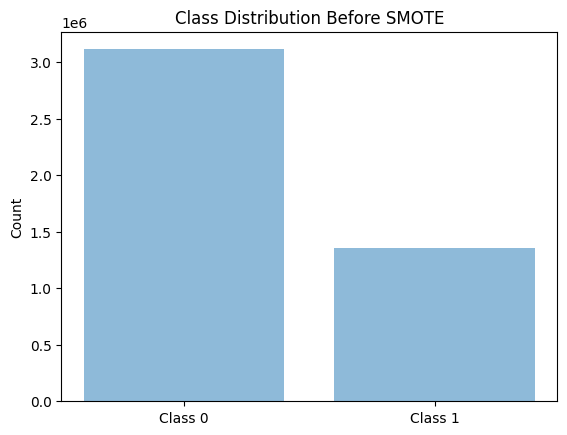

In [23]:
# Count the occurrences of 0s and 1s after SMOTE
unique_res, counts_res = np.unique(Y_train, return_counts=True)

# Create a bar chart
plt.bar(unique_res, counts_res, align='center', alpha=0.5)
plt.xticks(unique_res, ['Class 0', 'Class 1'])
plt.ylabel('Count')
plt.title('Class Distribution Before SMOTE')
plt.show()


### Feature Engineering

In [24]:
sm=SMOTE(random_state=40)
X_fet,Y_fet=sm.fit_resample(data_to_analyse[data_to_analyse.columns.difference(['Target'])],data_to_analyse['Target'])
print(data_to_analyse['Target'].value_counts()/data_to_analyse.shape[0])
print(Y_fet.value_counts()/Y_fet.shape[0])

Target
0    0.696945
1    0.303055
Name: count, dtype: float64
Target
0    0.5
1    0.5
Name: count, dtype: float64


### Train-Test Split

In [25]:
# Classifying 75% and 25% of data for train and test 
train_X,test_X,train_Y,test_Y=train_test_split(X_fet,Y_fet,random_state=38,test_size=0.15)

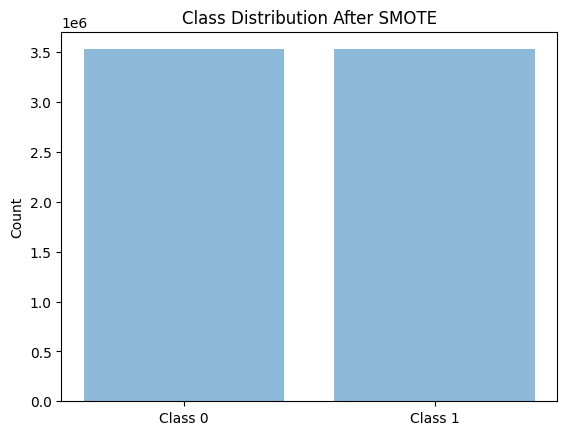

In [26]:
# Count the occurrences of 0s and 1s after SMOTE
unique_res, counts_res = np.unique(train_Y, return_counts=True)

# Create a bar chart
plt.bar(unique_res, counts_res, align='center', alpha=0.5)
plt.xticks(unique_res, ['Class 0', 'Class 1'])
plt.ylabel('Count')
plt.title('Class Distribution After SMOTE')
plt.show()


### Random Forest Classifier

In [27]:
Ran_model = RandomForestClassifier(random_state=61)
predictions = Ran_model.fit(train_X,train_Y)
print('Accuracy with Random Forest is: ',accuracy_score(test_Y,Ran_model.predict(test_X)))
print('F1 score with Random Forest is: ',f1_score(test_Y,Ran_model.predict(test_X)))

Accuracy with Random Forest is:  0.9180378280771142
F1 score with Random Forest is:  0.9232778822464829


### Classification Report

In [28]:
report = classification_report(test_Y, Ran_model.predict(test_X))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91    623393
           1       0.87      0.99      0.92    622084

    accuracy                           0.92   1245477
   macro avg       0.93      0.92      0.92   1245477
weighted avg       0.93      0.92      0.92   1245477

